In [1]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.optimize import curve_fit
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z


In [2]:
# 打开 ROOT 文件，载入 events tree
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
#Energy_Train=(0.5,)
Energy_test=(0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    #MCP_px = tree["MCParticles.momentum.x"].array(library="np")
    #MCP_py = tree["MCParticles.momentum.y"].array(library="np")
    #MCP_pz = tree["MCParticles.momentum.z"].array(library="np")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    #print to check
    # sorted_indices = np.argsort(calo_layer[0])
    # energy_sorted = energy[0][sorted_indices].to_numpy()
    # layer_sorted = calo_layer[0][sorted_indices].to_numpy()
    # posz_sorted = pos_z[0][sorted_indices].to_numpy()
    # print("Event 0 (sorted by layer):")
    # for l, e, z in zip(layer_sorted, energy_sorted, posz_sorted):
    #     print(f"  Layer {l:2d} | Energy = {e:.5f} | PosZ = {z:.5f }")

    num_events = len(energy)
    E_layers = []
    N_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)

    #print("Event 0:")
    #for layer_idx, (E_val, N_val) in enumerate(zip(E_layers_all[0], N_layers_all[0])):
    #    print(f"  Layer {layer_idx:2d} | E_layer = {E_val:.5f} | N_layer = {N_val}")
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_test, N_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/3.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/4.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/6.5GeV.root

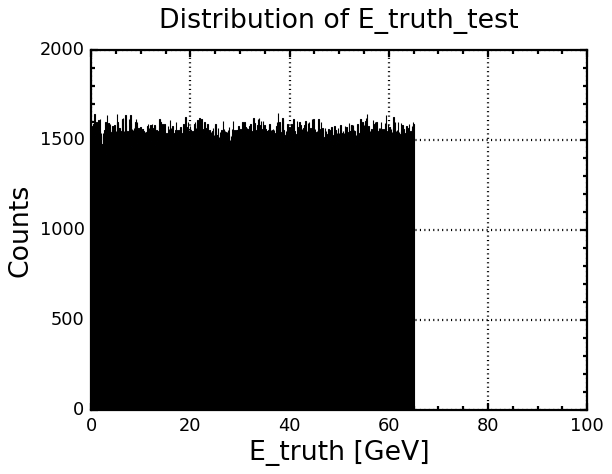

In [3]:
#Draw E_truth
plt.figure(figsize=fig_size)
plt.hist(E_truth_uniform, bins=1000, range=(0, 100), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.xlim(0, 100)
plt.ylabel("Counts")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()

In [4]:
#zero suppression
def zero_suppression(E_layers, N_layers,E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]    
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, E_truth = zero_suppression(E_layers, N_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    return E_layers, N_layers, E_sum, N_sum, E_truth

E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, E_truth_test)

length after zero suppression: 849995 849995 849995 849995 849995
length after zero suppression: 1000098 1000098 1000098 1000098 1000098
length after zero suppression: 50000 50000 50000 50000 50000


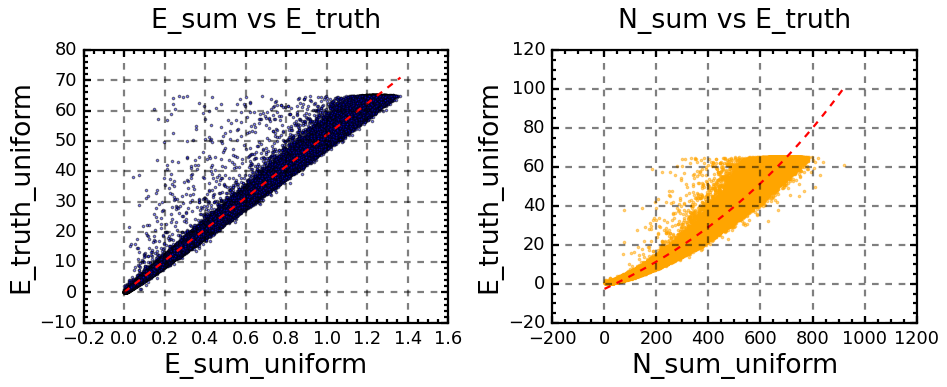

In [5]:
plt.figure(figsize=(12, 5))

coeffs_calibE = np.polyfit(E_sum_uniform, E_truth_uniform, 1)
E_fit_line = np.poly1d(coeffs_calibE)
plt.subplot(1, 2, 1)
plt.scatter(E_sum_uniform, E_truth_uniform, s=5, alpha=0.5)
x_line = np.linspace(min(E_sum_uniform), max(E_sum_uniform), 200)
plt.plot(x_line, E_fit_line(x_line), color="red", linestyle="--", label="Fit Line")
plt.xlabel("E_sum_uniform")
plt.ylabel("E_truth_uniform")
plt.title("E_sum vs E_truth")
plt.grid(True, linestyle="--", alpha=0.5)

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c
coeffs_calibN, _ = curve_fit(exp_func, N_sum_uniform, E_truth_uniform, p0=(1, 0.01, 1))
plt.subplot(1, 2, 2)
plt.scatter(N_sum_uniform, E_truth_uniform, s=5, alpha=0.5, color="orange")
x_line_N = np.linspace(min(N_sum_uniform), max(N_sum_uniform), 200)
plt.plot(x_line_N, exp_func(x_line_N, *coeffs_calibN), color="red", linestyle="--", label="Fit Line")
plt.xlabel("N_sum_uniform")
plt.ylabel("E_truth_uniform")
plt.title("N_sum vs E_truth")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

E_sum_train_calib = E_fit_line(E_sum_train)
E_sum_uniform_calib = E_fit_line(E_sum_uniform)
E_sum_test_calib = E_fit_line(E_sum_test)
N_sum_train_calib = exp_func(N_sum_train, *coeffs_calibN)
N_sum_uniform_calib = exp_func(N_sum_uniform, *coeffs_calibN)
N_sum_test_calib = exp_func(N_sum_test, *coeffs_calibN)

In [6]:
# ==== Prepare inputs for MLP ====
#ratio
E_ratio_train   = [layer / layer.sum() for layer in E_layers_train]
E_ratio_val     = [layer / layer.sum() for layer in E_layers_test]
E_ratio_uniform = [layer / layer.sum() for layer in E_layers_uniform]
N_ratio_train   = [layer / layer.sum() for layer in N_layers_train]
N_ratio_val     = [layer / layer.sum() for layer in N_layers_test]
N_ratio_uniform = [layer / layer.sum() for layer in N_layers_uniform]
#log
E_log_train = np.log(E_layers_train + 1)
E_log_test = np.log(E_layers_test + 1)
E_log_uniform = np.log(E_layers_uniform + 1)
N_log_train = np.log(N_layers_train + 1)
N_log_test = np.log(N_layers_test + 1)
N_log_uniform = np.log(N_layers_uniform + 1)

In [ ]:
# ==== Define MLP Model ====
class ParametricSELU(nn.Module):#hard to train
    def __init__(self, alpha=1.6733, lam=1.0507, init_b=1e-3):
        super().__init__()
        self.alpha = alpha
        self.lam = lam
        self.b = init_b
        #self.b = nn.Parameter(torch.tensor(init_b, dtype=torch.float32))

    def forward(self, x):
        pos = torch.where(x > 0, x, torch.zeros_like(x))
        b_clamped = torch.clamp(self.b, min=0.0)
        neg = torch.where(x <= 0, self.alpha * (torch.exp(b_clamped * x) - 1), torch.zeros_like(x))
        return self.lam * (pos + neg)

class ParametricSwish(nn.Module):
    def __init__(self):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))  # beta will be trainned

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)
    
class ParametricSigmoid(nn.Module):
    def __init__(self, beta=1.0, trainable=False, beta_min=-10.0, beta_max=10.0):
        """
        Parametric sigmoid: σ(beta * x)
        beta: initial value
        trainable: whether beta is learnable
        beta_min, beta_max: clipping range for trainable beta
        """
        super().__init__()
        self.beta_min = beta_min
        self.beta_max = beta_max

        if trainable:
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))
        else:
            self.register_buffer('beta', torch.tensor(beta, dtype=torch.float32))

    def forward(self, x):
        beta = self.beta.to(x.device).type_as(x)
        z = beta * x
        out = torch.sigmoid(z)
        return out
    
class WeightedRelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8, power=1):
        super().__init__()
        self.eps = eps
        self.power = power  # 控制权重下降速度

    def forward(self, y_pred, y_true):
        weight = 1.0 / (y_true + self.eps) ** self.power
        return torch.mean(weight * ((y_true - y_pred) / (y_true + self.eps)) ** 2)
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)

class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.linear(x)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

# ===== MLP 回归模型 =====
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.1, Activate_beta=1.0, Activate_trainable=True):
        super().__init__()
        #print("MLPRegressor ParametricSigmoid beta:", Activate_beta,"Trainable:", Activate_trainable)
        print("Use nn.sigmoid, MLPRegressor")
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=nn.PReLU()))
            prev_dim = h
        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)

    def forward(self, x):
        x = self.model(x)
        return self.output_layer(x).squeeze(-1)

# ==== Training function ====
def train_mlp(X,y,
              Activate_beta=1.0,Activate_trainable=False, 
              hidden_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3, 
              batch_size=4096, 
              epochs=500,
              patience=10,
              val_split=0.2,
              random_state=42):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(X)}, Validation samples: {int(len(X)*val_split)}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=val_split, random_state=random_state)

    #Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_validate = scaler.transform(X_validate)

    # Convert numpy arrays to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_validate   = torch.tensor(X_validate, dtype=torch.float32)
    y_validate   = torch.tensor(y_validate, dtype=torch.float32)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset   = TensorDataset(X_validate, y_validate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model = MLPRegressor(input_dim=X_train.shape[1], hidden_dims=hidden_dims, dropout=dropout,
                         Activate_beta=Activate_beta, Activate_trainable=Activate_trainable).to(device)

    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = RelativeMSELoss()

    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item() * xb.size(0)

        train_loss /= len(train_dataset)
        val_loss   /= len(val_dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Relative MSE)")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return model + scaler so predictions can use same transform
    return model, scaler
    
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

In [107]:
#X_train = np.hstack([E_layers_uniform, N_layers_uniform])
#X_val = np.hstack([E_layers_test, N_layers_test])
#X_train = np.hstack([E_layers_uniform, E_ratio_uniform, E_sum_uniform[:, np.newaxis], N_layers_uniform, N_ratio_uniform, N_sum_uniform[:, np.newaxis]])
#X_val = np.hstack([E_layers_test, E_ratio_val, E_sum_test[:, np.newaxis], N_layers_test, N_ratio_val, N_sum_test[:, np.newaxis]])
#X_train = np.hstack([E_layers_uniform,E_log_uniform, E_sum_uniform[:, np.newaxis],N_layers_uniform,N_log_uniform,N_sum_uniform[:,np.newaxis]])
#X_val = np.hstack([E_layers_test,E_log_test,E_sum_test[:, np.newaxis], N_layers_test,N_log_test,N_sum_test[:,np.newaxis]])

#X = np.hstack([E_layers_uniform, N_layers_uniform])
X_train = np.hstack([E_layers_uniform, E_sum_uniform_calib[:,np.newaxis],N_layers_uniform, N_sum_uniform_calib[:,np.newaxis]])
#X_validate = np.hstack([E_layers_train, N_layers_train])
X_test = np.hstack([E_layers_test, E_sum_test_calib[:,np.newaxis], N_layers_test, N_sum_test_calib[:,np.newaxis]])
#y_train = np.log(E_truth_uniform+1)
#y_val = np.log(E_truth_test+1)
y_train = E_truth_uniform
#y_validate = E_truth_train
y_test = E_truth_test

def plot_features_in_batches(X, feature_names=None, bins=50, n_cols=2, figsize=(12, 6)):
    n_features = X.shape[1]
    n_rows = (n_cols + n_cols - 1) // n_cols  # 每页只有 1 行 2 列的话 n_rows=1
    for start in range(0, n_features, n_cols):
        end = min(start + n_cols, n_features)
        plt.figure(figsize=figsize)
        for i, j in enumerate(range(start, end)):
            plt.subplot(1, n_cols, i + 1)
            plt.hist(X[:, j], bins=bins, color='skyblue', edgecolor='black')
            plt.yscale('log')
            if feature_names:
                plt.title(feature_names[j], fontsize=10)
            else:
                plt.title(f"Feature {j}", fontsize=10)
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.show()

Using device: cuda
Random state: 42
Training samples: 1000098, Validation samples: 100009
learning rate: 0.001, batch size: 4096, epochs: 50, patience: 5
Use nn.sigmoid, MLPRegressor
Epoch 001/50 | Train Loss: 0.308128 | Val Loss: 0.034217
Epoch 002/50 | Train Loss: 0.032994 | Val Loss: 0.013593
Epoch 003/50 | Train Loss: 0.021377 | Val Loss: 0.009510
Epoch 004/50 | Train Loss: 0.016840 | Val Loss: 0.006225
Epoch 005/50 | Train Loss: 0.014580 | Val Loss: 0.005466
Epoch 006/50 | Train Loss: 0.013614 | Val Loss: 0.004430
Epoch 007/50 | Train Loss: 0.012770 | Val Loss: 0.004189
Epoch 008/50 | Train Loss: 0.012315 | Val Loss: 0.004536
Epoch 009/50 | Train Loss: 0.012041 | Val Loss: 0.004704
Epoch 010/50 | Train Loss: 0.011559 | Val Loss: 0.003716
Epoch 011/50 | Train Loss: 0.011077 | Val Loss: 0.003590
Epoch 012/50 | Train Loss: 0.011044 | Val Loss: 0.003781
Epoch 013/50 | Train Loss: 0.010783 | Val Loss: 0.003562
Epoch 014/50 | Train Loss: 0.010773 | Val Loss: 0.004039
Epoch 015/50 | Trai

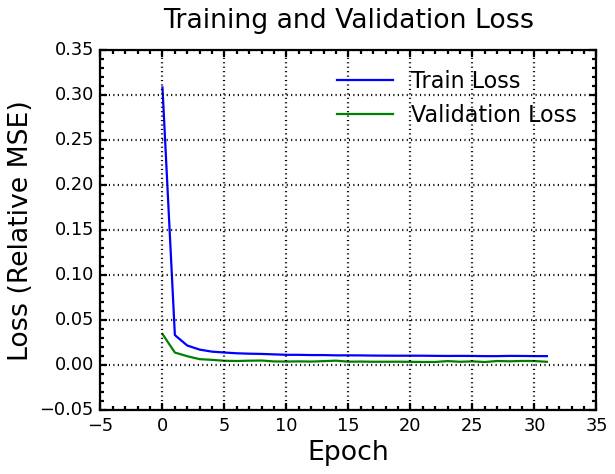

In [108]:
Sigmoid_beta=[-1,]#-1 for nn.sigmoid
Reco_hist_mlp_all = []
for beta in Sigmoid_beta:
  mlp_model,scaler = train_mlp(X_train, y_train,
                    Activate_beta=beta,Activate_trainable=False,
                    hidden_dims=[128, 64, 32],
                      dropout=0.1,
                      lr=1e-3,
                      batch_size=4096,
                      epochs=50,
                      patience=5,
                      val_split=0.1,
                      random_state=42)
  device = next(mlp_model.parameters()).device
  X_test = scaler.transform(X_test)
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
  mlp_model.eval()
  with torch.no_grad():
    y_pred_test_mlp = mlp_model(X_test_tensor).cpu().numpy()
    #y_pred_val_mlp = np.exp(y_pred_val_mlp)-1
  Reco_hist_mlp = build_reco_hist(y_pred_test_mlp, E_truth_test, Energy_test, Nbins=50)
  Reco_hist_mlp_all.append(Reco_hist_mlp)


In [109]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


Mean: 1.8572239768981933, Peak: 1.7191808223724365, RMS: 0.2533902517449687
Initial Gamma Fit Parameters: [np.float64(220.20667791366577), np.float64(4.1078565375921405), np.float32(0.8163332), np.float64(0.2533902517449687)]
Gamma Fit Parameters: [2.20128337e+02 3.45229482e+01 3.77044025e-01 4.28797560e-02]
Gamma Fit Peak: 1.8144998660475815 ± 0.004529985474271418, Resolution: 0.13885109326797218 ± 0.0018502601427830832


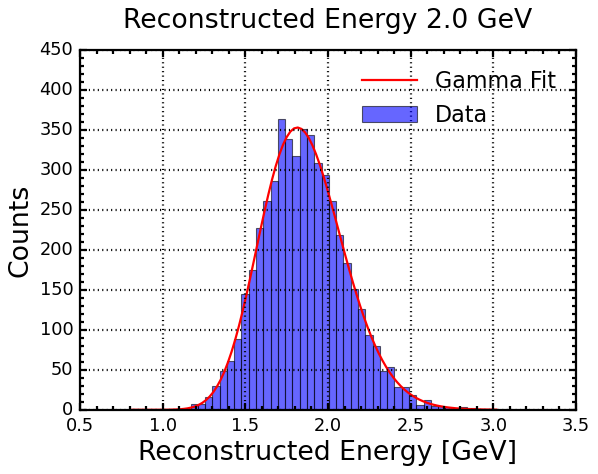

In [110]:
#This cell is left here for debug
Reco_hist_mlp = Reco_hist_mlp_all[0] # Example for first beta
i_E = 2  # Example index, change as needed
#print(len(Reco_hist_mlp))
#print(Reco_hist_mlp[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist_mlp[i_E]["E_truth"],Reco_hist_mlp[i_E]["counts"],Reco_hist_mlp[i_E]["bin_edges"])





Mean: 0.4424373609652684, Peak: 0.3867143392562866, RMS: 0.09010663387352136
Initial Gamma Fit Parameters: [np.float64(71.09762062132359), np.float64(2.9070811777544887), np.float32(0.18049006), np.float64(0.09010663387352136)]
Gamma Fit Parameters: [6.98753608e+01 6.21720430e+00 2.32189151e-01 3.33369932e-02]
Gamma Fit Peak: 0.40611505541497084 ± 0.0017849114831558946, Resolution: 0.20467976354327197 ± 0.004572523243305899


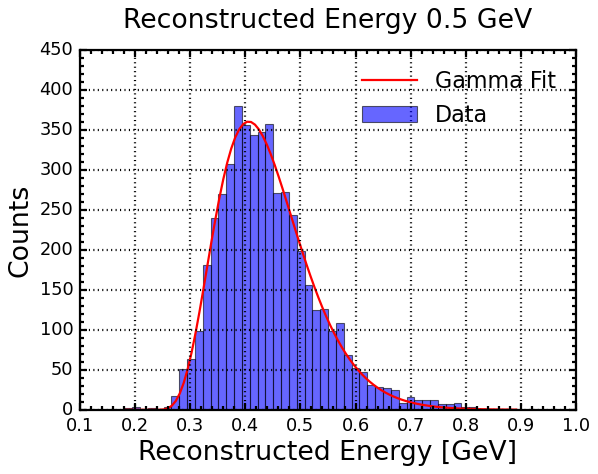

Mean: 0.9123696602745327, Peak: 0.8352206349372864, RMS: 0.18314385096299002
Initial Gamma Fit Parameters: [np.float64(134.00675404071808), np.float64(3.421826786549784), np.float32(0.28568313), np.float64(0.18314385096299002)]
Gamma Fit Parameters: [ 1.34362632e+02  3.42182679e+01 -1.72117471e-01  3.19351039e-02]
Gamma Fit Peak: 0.888711364868932 ± 0.004335339719256586, Resolution: 0.2102018870920789 ± 0.0037779311909352914


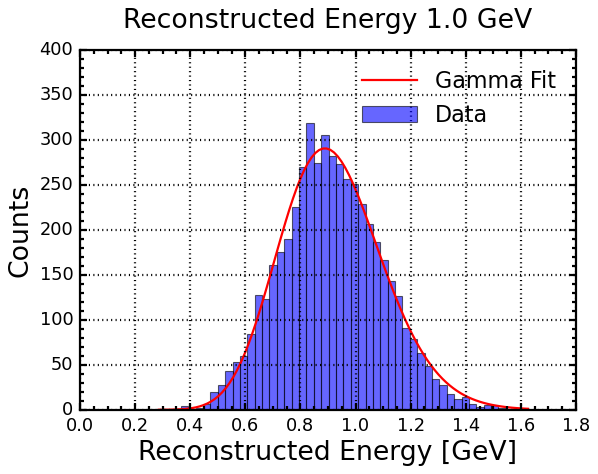

Mean: 1.8572239768981933, Peak: 1.7191808223724365, RMS: 0.2533902517449687
Initial Gamma Fit Parameters: [np.float64(220.20667791366577), np.float64(4.1078565375921405), np.float32(0.8163332), np.float64(0.2533902517449687)]
Gamma Fit Parameters: [2.20128337e+02 3.45229482e+01 3.77044025e-01 4.28797560e-02]
Gamma Fit Peak: 1.8144998660475815 ± 0.004529985474271418, Resolution: 0.13885109326797218 ± 0.0018502601427830832


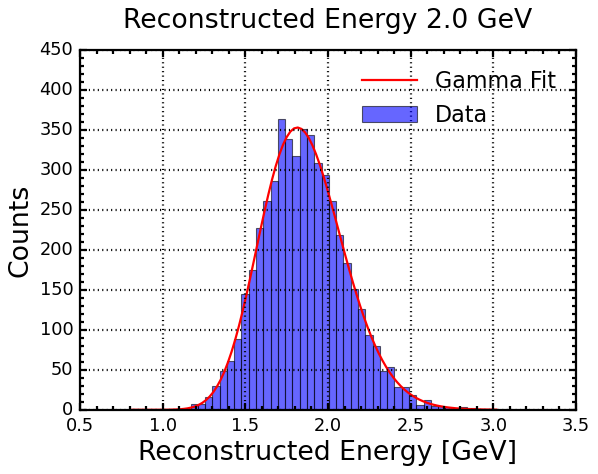

Mean: 4.810088991069374, Peak: 4.7142333984375, RMS: 0.42187747213317095
Initial Gamma Fit Parameters: [np.float64(327.1140990257263), np.float64(3.2523892844703868), np.float32(3.4379792), np.float64(0.42187747213317095)]
Gamma Fit Parameters: [3.28136325e+02 3.25238928e+01 2.38266777e+00 7.50714276e-02]
Gamma Fit Peak: 4.749211411316965 ± 0.008786997104729436, Resolution: 0.0901476547968612 ± 0.0013439760255545743


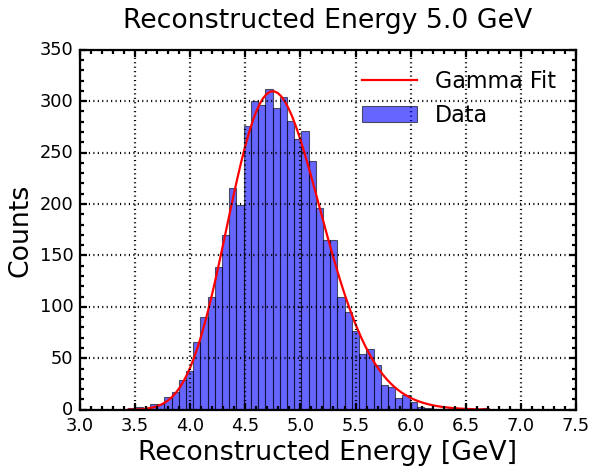

Mean: 9.726737077522278, Peak: 9.521612167358398, RMS: 0.605724405060399
Initial Gamma Fit Parameters: [np.float64(494.992733001709), np.float64(4.179435737060116), np.float32(7.195151), np.float64(0.605724405060399)]
Gamma Fit Parameters: [4.92570917e+02 4.17943574e+01 5.89768491e+00 9.25051994e-02]
Gamma Fit Peak: 9.671375075703924 ± 0.012354394296832268, Resolution: 0.06183533855798248 ± 0.0008953812213282531


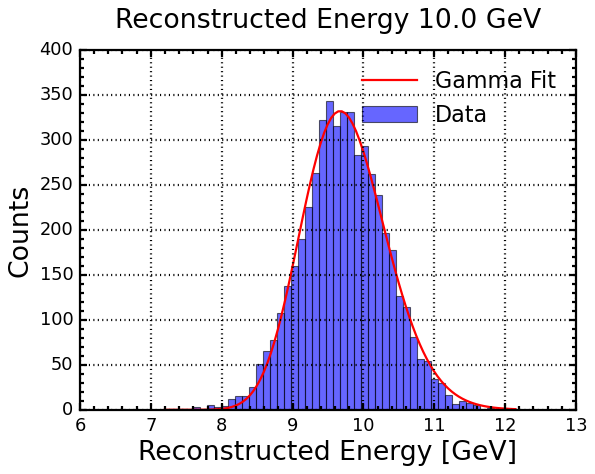

Mean: 19.649194540906876, Peak: 19.829923629760742, RMS: 0.8572936860080443
Initial Gamma Fit Parameters: [np.float64(847.4964065551758), np.float64(4.832921541797221), np.float32(15.505961), np.float64(0.8572936860080443)]
Gamma Fit Parameters: [8.48040555e+02 4.83292154e+01 1.37155329e+01 1.23755253e-01]
Gamma Fit Peak: 19.572771906931614 ± 0.0162493596832419, Resolution: 0.04395579920468711 ± 0.0005713412233344029


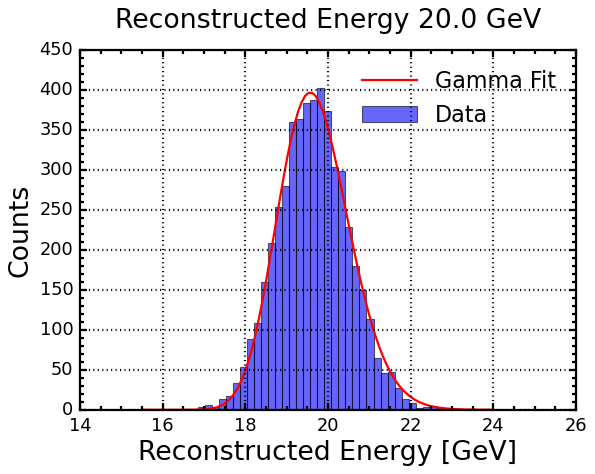

Mean: 29.758822441292, Peak: 29.347150802612305, RMS: 1.0625335505943019
Initial Gamma Fit Parameters: [np.float64(930.4460334777832), np.float64(4.5072904987578), np.float32(24.969675), np.float64(1.0625335505943019)]
Gamma Fit Parameters: [9.30928852e+02 4.50729050e+01 2.26587157e+01 1.58983707e-01]
Gamma Fit Peak: 29.665589493567474 ± 0.02503185591046836, Resolution: 0.03597968960958264 ± 0.0005817616613597707


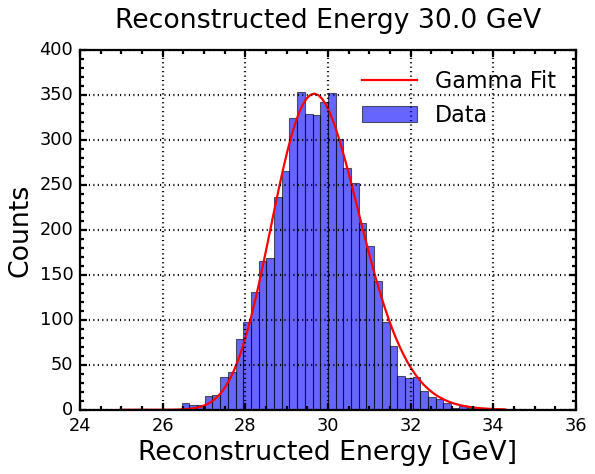

Mean: 39.782220691973286, Peak: 39.7278938293457, RMS: 1.1938907166867583
Initial Gamma Fit Parameters: [np.float64(1128.587272644043), np.float64(4.869470521224181), np.float32(33.968605), np.float64(1.1938907166867583)]
Gamma Fit Parameters: [1.12679766e+03 4.86947052e+01 3.15851620e+01 1.69863900e-01]
Gamma Fit Peak: 39.6867706169973 ± 0.01904100088142011, Resolution: 0.029867316272732036 ± 0.00032823923104262565


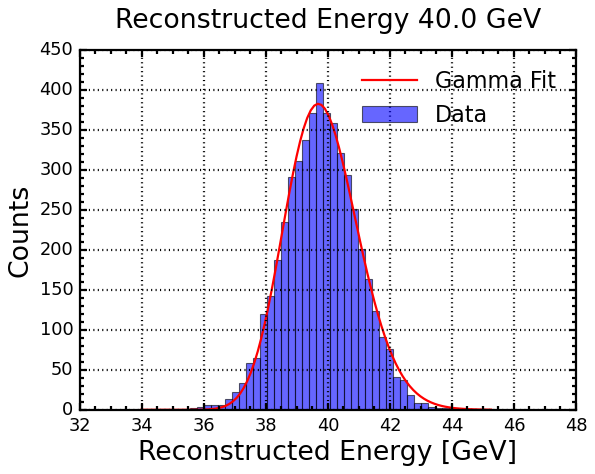

Mean: 49.553835412315614, Peak: 49.77920913696289, RMS: 1.2849842340264237
Initial Gamma Fit Parameters: [np.float64(1006.6307563781738), np.float64(4.290754752619974), np.float32(44.040283), np.float64(1.2849842340264237)]
Gamma Fit Parameters: [1.00349219e+03 4.29075475e+01 4.12357887e+01 1.95775027e-01]
Gamma Fit Peak: 49.440239951457116 ± 0.03448061227748696, Resolution: 0.025938423030240947 ± 0.00048090418435098217


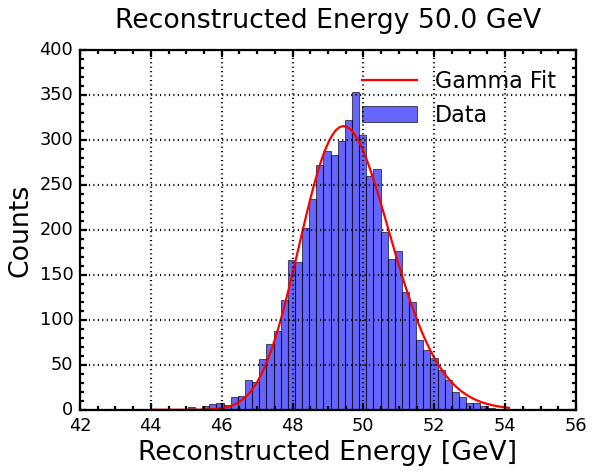

Mean: 59.03398437087848, Peak: 59.336181640625, RMS: 1.3923580882703726
Initial Gamma Fit Parameters: [np.float64(1241.5876693725586), np.float64(4.867764337350378), np.float32(52.256313), np.float64(1.3923580882703726)]
Gamma Fit Parameters: [1.23872133e+03 4.86776434e+01 4.94421143e+01 1.99058120e-01]
Gamma Fit Peak: 58.93273633766375 ± 0.03715423130782078, Resolution: 0.023566118825354976 ± 0.00043034408717591193


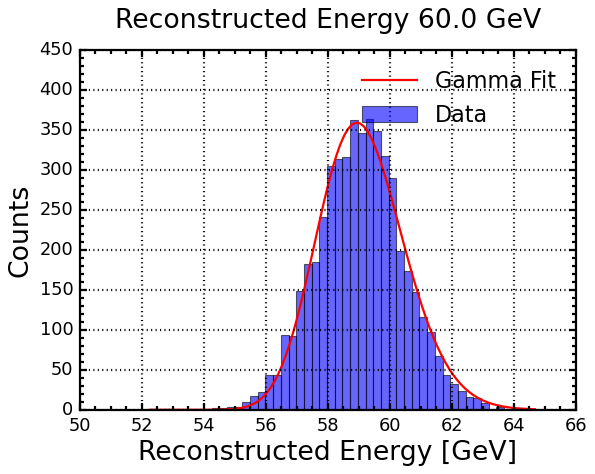

In [111]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
outputfile_name = os.path.join(DataPath_Validate, f"RecoE_MLP_Fit.csv")
OutputCSV(Reco_hist_mlp_all[0], Energy_test, outputfile_name)
# for i_beta, beta in enumerate(Sigmoid_beta):
#     outputfile_name = os.path.join(DataPath_Validate, f"RecoE_MLP_Fit_Beta{beta:.1f}.csv")
#     OutputCSV(Reco_hist_mlp_all[i_beta], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")